<a href="https://colab.research.google.com/github/Youssef-Ghallab/Deep-Learning-Assignment-1/blob/main/pytorch_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
from google.colab import files
files.upload()
import io
df = pd.read_csv('/content/Housing-1.csv')


Saving Housing-1.csv to Housing-1.csv


In [5]:
input = (df.drop('price', axis=1))
y = np.array(df['price']).reshape(-1,1)
y.shape
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


In [6]:
input.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [7]:
string_columns = input.select_dtypes(['object']).columns.tolist()

for column in string_columns:
    one_hot = pd.get_dummies(input[column], prefix=column)
    input = pd.concat([input, one_hot], axis=1)
    input = input.drop(column, axis=1)

input.head()


,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,7420,4,2,3,2,False,True,True,False,True,False,True,False,False,True,False,True,True,False,False
1,8960,4,4,4,3,False,True,True,False,True,False,True,False,False,True,True,False,True,False,False
2,9960,3,2,2,2,False,True,True,False,False,True,True,False,True,False,False,True,False,True,False
3,7500,4,2,2,3,False,True,True,False,False,True,True,False,False,True,False,True,True,False,False
4,7420,4,1,2,2,False,True,False,True,False,True,True,False,False,True,True,False,True,False,False


In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size,16)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.LeakyReLU()
        self.linear2 = nn.Linear(16,8)
        self.relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(8,1)

    def forward(self, x):
        x = self.linear(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return self.output(x)

Epoch [50/350], Loss: 0.4077, LR: 0.015000
Epoch [100/350], Loss: 0.3697, LR: 0.007500
Epoch [150/350], Loss: 0.3580, LR: 0.003750
Epoch [200/350], Loss: 0.3831, LR: 0.001875
Epoch [250/350], Loss: 0.3585, LR: 0.000937
Epoch [300/350], Loss: 0.3501, LR: 0.000469
Epoch [350/350], Loss: 0.3582, LR: 0.000234
Test Loss: 0.6164


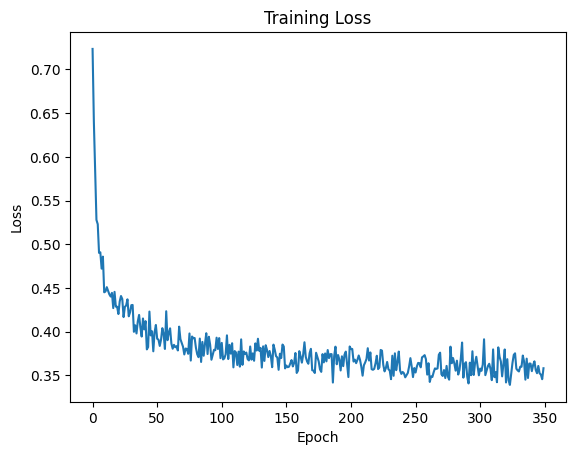

In [9]:
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(input, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Hyperparameters
learning_rate = 0.03
num_epochs = 350
step_size = 50 # Step size after which the LR is updated
gamma = 0.5  # Factor by which the learning rate will be reduced

# Create the model
model = LinearRegressionModel(input_size=20)

# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Compute the loss
    loss = criterion(y_pred, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Step the learning rate scheduler
    scheduler.step()
    if (epoch+1) % 50 == 0:
      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    y_pred_test = model(X_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [12]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    y_pred_test = model(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")




Mean Squared Error (MSE): 0.6812
Mean Absolute Error (MAE): 0.6164
R-squared (R2): 0.5844


#Plots
The red line denotes Predicted = Actual
A Logarithmic growth curve would fit the data better than the linear discriminator

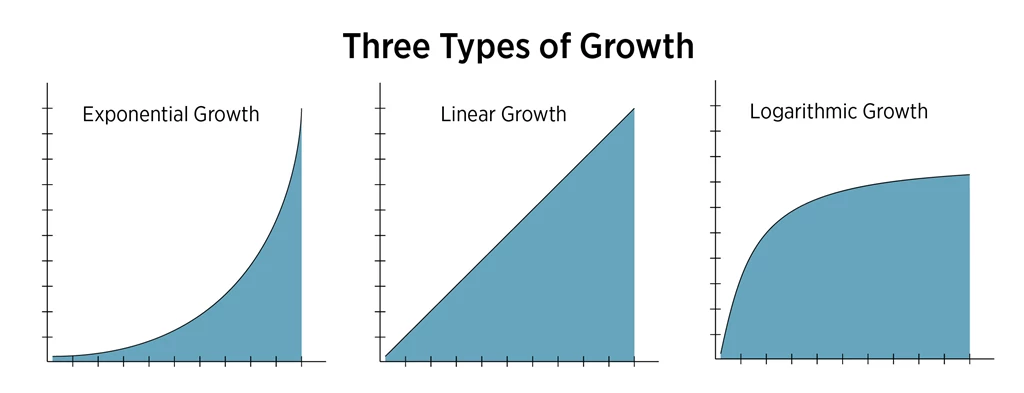


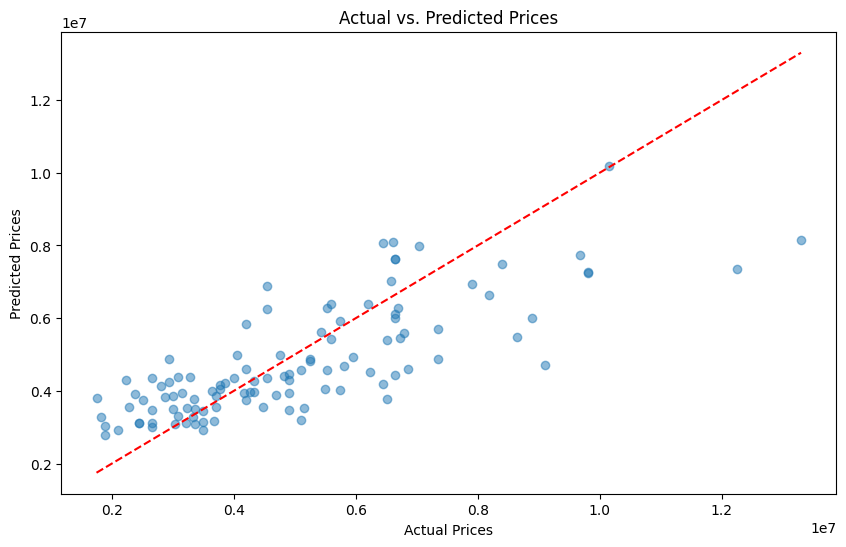

In [13]:
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.numpy())
y_test_inverse = scaler_y.inverse_transform(y_test.numpy())
# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inverse, y_pred_test_inverse, alpha=0.5)
plt.plot([min(y_test_inverse), max(y_test_inverse)], [min(y_test_inverse), max(y_test_inverse)], color='red', linestyle='--') # Add a diagonal line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")
plt.show()